# Train mobilenet with custom dataset
<a target="_blank" href="https://colab.research.google.com/github/SonySemiconductorSolutions/aitrios-rpi-tutorials-ai-model-training/blob/main/notebooks/mobilenet-rps/custom_mobilenet.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This tutorial will guide you through the process of creating and training an image classification model for deployment on Raspberry Pi AI Camera.

We will normalize the float inputs in preprocessing, and augment our dataset with random preprocessing to avoid overfitting, before training and saving the model as a Keras model. Post-training quantization with [Model Compression Toolkit, MCT](https://github.com/sony/model_optimization/tree/main) developed by Sony Semiconductor Israel.

Tutorial includes:
- Dataset setup
- Model creation
- Training
- Quantization using [Model Compression Toolkit - MCT](https://github.com/sony/model_optimization)
- Evaluation
- Visualization
- Conversion

In [1]:
# Check GPU
!nvidia-smi

/bin/bash: línea 1: nvidia-smi: orden no encontrada


# Installation

In [2]:
!pip -q install tensorflow~=2.14.0 model-compression-toolkit~=2.2.0 imx500-converter[tf]

In [3]:
# Converter requires java
import os
import re
import subprocess

def install_java(package: str = 'openjdk-17-jdk', version: int = 17) -> bool:
    try:
        result = subprocess.run(['java', '--version'], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        version_output = result.stdout.splitlines()[0]
        match = re.search(r'(\d+)\.(\d+)\.(\d+)', version_output)  # Match version in form major.minor.patch
        print(f"Found Java version: {match.group(0)}")
        if match:
            major_version = int(match.group(1))
            if major_version == version:
                return True
            else:
                print(f"Java {version} is not installed. Installing correct version...")
    except (subprocess.CalledProcessError, FileNotFoundError) as e:
        print(f"Java not installed. Installing...")
    
    try:
        is_root = os.geteuid() == 0
        prefix = [] if is_root else ['sudo']
        with open(os.devnull, 'w') as devnull:
            subprocess.run(prefix + ['apt', 'install', '-y', package], check=True, stdout=devnull, stderr=devnull)
        return True
    except subprocess.CalledProcessError as e:
        print(f"Installation error: {e}")
        return False

if install_java():
    print(f'Java installed')
else:
    print(f'Java missing and installation failed')

Found Java version: 21.0.7
Java 17 is not installed. Installing correct version...
Installation error: Command '['sudo', 'apt', 'install', '-y', 'openjdk-17-jdk']' returned non-zero exit status 1.
Java missing and installation failed


# Settings
Let’s set up some variables we can use later when pre-processing the dataset and training our network.

In [4]:
import os

MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL = MODELS_DIR + 'mobilenet-rps'
MODEL_KERAS = MODELS_DIR + 'mobilenet-quant-rps.keras'

BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

# Dataset
We will use the RPS dataset from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors)

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import keras

2025-07-24 12:59:34.498214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 12:59:34.540711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 12:59:34.540796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 12:59:34.540862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-24 12:59:34.553992: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 12:59:34.556273: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [6]:
# Load the RPS dataset
dataset_name = "rock_paper_scissors"
(train_ds, validation_ds), info = tfds.load(
    name=dataset_name,
    split=["train", "test"],
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
    batch_size=BATCH_SIZE
)

# Display dataset information
print(info)

class_names = info.features['label'].names
num_classes = len(class_names)
print("class_names:", class_names)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/home/daniel/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.c

## Pre-processing and augmentation

In [7]:
def preprocess_data(image, label):
    # Set range
    image = tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(image, tf.float32))
    # Resize image
    image = tf.image.resize(image, IMAGE_SHAPE)
    return image, label

train_ds = train_ds.map(preprocess_data)
validation_ds = validation_ds.map(preprocess_data)

In [8]:
# Add augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Keras Mobilenetv2 model for transfer learning

In [9]:
from keras.applications import MobileNetV2
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE+(3,))

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation=tf.nn.softmax)(x)

# Create the full model
float_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

float_model.summary()
"""
Top and buttom layers.
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to
==================================================================================================
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []

 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']
 ...
 global_average_pooling2d (  (None, 1280)                 0         ['out_relu[0][0]']
 GlobalAveragePooling2D)

 dense (Dense)               (None, 3)                    3843      ['global_average_pooling2d[0][
                                                                    0]']

==================================================================================================
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
__________________________________________________________________________________________________
"""

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

"\nTop and buttom layers.\n__________________________________________________________________________________________________\n Layer (type)                Output Shape                 Param #   Connected to\n==================================================================================================\n input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []\n\n Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']\n ...\n global_average_pooling2d (  (None, 1280)                 0         ['out_relu[0][0]']\n GlobalAveragePooling2D)\n\n dense (Dense)               (None, 3)                    3843      ['global_average_pooling2d[0][\n                                                                    0]']\n\n==================================================================================================\nTotal params: 2261827 (8.63 MB)\nTrainable params: 3843 (15.01 KB)\nNon-trainable params: 2257984 (8.61 MB)\n_______________________

# Train

In [10]:
EPOCHS = 6

float_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    baseline=0.8,
    min_delta=0.01,
    mode='max',
    patience=5,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=5,
)

history = float_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS,
    callbacks=[callback]
)

float_model.save(MODEL)

Epoch 1/6


2025-07-24 12:59:46.119188: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-07-24 12:59:46.181827: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


 1/79 [..............................] - ETA: 3:53 - loss: 1.3821 - accuracy: 0.4375

2025-07-24 12:59:46.678095: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-07-24 12:59:46.716777: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


 2/79 [..............................] - ETA: 36s - loss: 1.4384 - accuracy: 0.3438 

2025-07-24 12:59:47.141613: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


79/79 [==============================] - 45s 540ms/step - loss: 0.4414 - accuracy: 0.8567 - val_loss: 0.5001 - val_accuracy: 0.7581
Epoch 2/6
79/79 [==============================] - 43s 537ms/step - loss: 0.1105 - accuracy: 0.9857 - val_loss: 0.3543 - val_accuracy: 0.8575
Epoch 3/6
79/79 [==============================] - 42s 529ms/step - loss: 0.0696 - accuracy: 0.9889 - val_loss: 0.4547 - val_accuracy: 0.7930
Epoch 4/6
79/79 [==============================] - 42s 533ms/step - loss: 0.0505 - accuracy: 0.9956 - val_loss: 0.4110 - val_accuracy: 0.8091
Epoch 5/6
79/79 [==============================] - 43s 539ms/step - loss: 0.0381 - accuracy: 0.9972 - val_loss: 0.3680 - val_accuracy: 0.8172
Epoch 6/6
79/79 [==============================] - 43s 539ms/step - loss: 0.0301 - accuracy: 0.9972 - val_loss: 0.3682 - val_accuracy: 0.8199
INFO:tensorflow:Assets written to: models/mobilenet-rps/assets


INFO:tensorflow:Assets written to: models/mobilenet-rps/assets


# Quantization
For full integer quantization, you need to calibrate or estimate the range (Min, Max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers), and model output cannot be calibrated unless we run a few inference cycles. For this, the converter requires a representative dataset to calibrate with. This dataset can be a small subset (around 100-500 samples) of the training or validation data.

For details, see [Post-Training Quantization Example of MobileNetV2 Keras Model](https://github.com/sony/model_optimization/blob/v2.0.0/tutorials/notebooks/keras/ptq/example_keras_imagenet.ipynb)

Observe that we are using training part of the dataset as representative dataset.



In [11]:
from typing import Generator

n_iter=10

# Create representative dataset generator
def get_representative_dataset() -> Generator:
    """A function that loads the dataset and returns a representative dataset generator.

    Returns:
        Generator: A generator yielding batches of preprocessed images.
    """
    dataset = train_ds

    def representative_dataset() -> Generator:
        """A generator function that yields batch of preprocessed images.

        Yields:
            A batch of preprocessed images.
        """
        for _ in range(n_iter):
            yield dataset.take(1).get_single_element()[0].numpy()

    return representative_dataset

# Create a representative dataset generator
representative_dataset_gen = get_representative_dataset()

In [12]:
import model_compression_toolkit as mct
from model_compression_toolkit.core import QuantizationErrorMethod

# Specify the IMX500-v1 target platform capability (TPC)
tpc = mct.get_target_platform_capabilities("tensorflow", 'imx500', target_platform_version='v1')

# Set the following quantization configurations:
# Choose the desired QuantizationErrorMethod for the quantization parameters search.
# Enable weights bias correction induced by quantization.
# Enable shift negative corrections for improving 'signed' non-linear functions quantization (such as swish, prelu, etc.)
# Set the threshold to filter outliers with z_score of 16.
q_config = mct.core.QuantizationConfig(activation_error_method=QuantizationErrorMethod.MSE,
                                       weights_error_method=QuantizationErrorMethod.MSE,
                                       weights_bias_correction=True,
                                       shift_negative_activation_correction=True,
                                       z_threshold=16)

ptq_config = mct.core.CoreConfig(quantization_config=q_config)

In [13]:
quantized_model, quantization_info = mct.ptq.keras_post_training_quantization(
    in_model=float_model,
    representative_data_gen=representative_dataset_gen,
    core_config=ptq_config,
    target_platform_capabilities=tpc)

Statistics Collection: 10it [00:53,  5.33s/it]



Running quantization parameters search. This process might take some time, depending on the model size and the selected quantization methods.



Calculating quantization parameters: 100%|██████████| 105/105 [00:11<00:00,  8.89it/s]


Weights_memory: 2193600.0, Activation_memory: 1204224.0, Total_memory: 3397824.0, BOPS: 45502021632.0

Please run your accuracy evaluation on the exported quantized model to verify it's accuracy.
Checkout the FAQ and Troubleshooting pages for resolving common issues and improving the quantized model accuracy:
FAQ: https://github.com/sony/model_optimization/tree/main/FAQ.md
Quantization Troubleshooting: https://github.com/sony/model_optimization/tree/main/quantization_troubleshooting.md


In [14]:
# Export the quantized model
mct.exporter.keras_export_model(model=quantized_model, save_model_path=MODEL_KERAS)

Exporting Keras model with MCTQ custom quantizers to: models/mobilenet-quant-rps.keras


{}

# Evaluation

In [15]:
float_model.evaluate(validation_ds)

12/12 [==============================] - 5s 417ms/step - loss: 0.3682 - accuracy: 0.8199


[0.36815187335014343, 0.8198924660682678]

In [16]:
quantized_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
quantized_model.evaluate(validation_ds)

12/12 [==============================] - 9s 595ms/step - loss: 0.4110 - accuracy: 0.8091


[0.4109794497489929, 0.8091397881507874]

# Visualize detections

In [17]:
import matplotlib.pyplot as plt
# Load the test part of the dataset
test_ds, info = tfds.load(dataset_name, split=["test"], with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir='/home/daniel/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.c

In [18]:
# Preprocess the input image for inference
def preprocess_image_visualization(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

# Perform detection on the input image
def detect_objects(model, image):
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    return predictions

# Get the class label and confidence score of the detected objects
def get_top_prediction(predictions):
    top_idx = np.argsort(predictions)[0][-1]
    top_score = predictions[0][top_idx]
    top_class = class_names[top_idx]
    return top_class, top_score

# Visualize the detections
def visualize_detection(image, cls, score):
    plt.imshow(image)
    plt.text(10, 20, f'{cls}: {score}', color='red')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 917ms/step
cls: scissors, score: 0.99609375


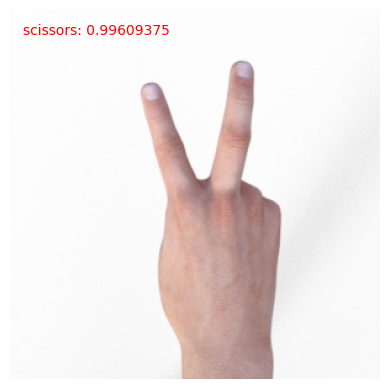

1/1 [==============================] - 0s 38ms/step
cls: paper, score: 0.7734375


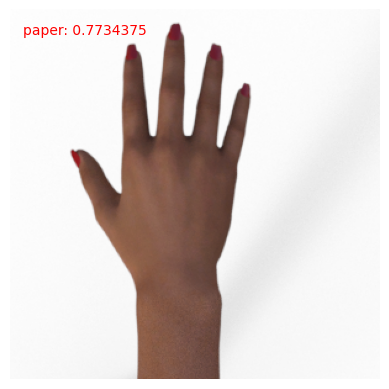

1/1 [==============================] - 0s 32ms/step
cls: scissors, score: 0.88671875


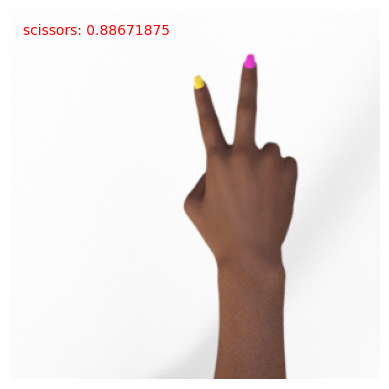

1/1 [==============================] - 0s 32ms/step
cls: rock, score: 0.9609375


2025-07-24 13:05:41.087427: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


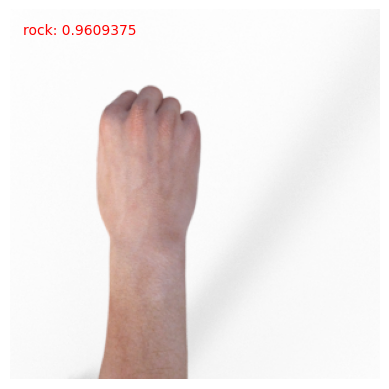

In [19]:
# Visualize detection results for some images
for sample in test_ds[0].take(4):
    image = preprocess_image_visualization(sample['image'])
    predictions = detect_objects(quantized_model, image)  # float_model/quantized_model
    cls, score = get_top_prediction(predictions)
    print(f'cls: {cls}, score: {score}')
    assert score > 0.55
    visualize_detection(sample['image'], cls, score)

# Conversion
For details see
* [Raspberry Pi Documentation](https://www.raspberrypi.com/documentation/accessories/ai-camera.html#conversion)
* [Sony IMX500 Converter documentation](https://developer.aitrios.sony-semicon.com/en/raspberrypi-ai-camera/documentation/imx500-converter)

In [20]:
!imxconv-tf -i {MODEL_KERAS} -o converted

2025-07-24 13:05:42,053 INFO : Running version 3.16.1 [/home/daniel/.venv_tf2/lib/python3.11/site-packages/uni/common/logger.py:179]
2025-07-24 13:05:42,053 INFO : Converting models/mobilenet-quant-rps.keras [/home/daniel/.venv_tf2/lib/python3.11/site-packages/uni/common/logger.py:179]
2025-07-24 13:05:42.368873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-24 13:05:42.416083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-24 13:05:42.416126: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-24 13:05:42.416162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register fa

In [21]:
"""
# Expected output from converter:
dnnParams.xml		   mobilenet-quant-rps_MemoryReport.json
mobilenet-quant-rps.pbtxt  packerOut.zip
"""
!ls converted
assert os.path.exists("converted/packerOut.zip"), f"Converted file not found"

dnnParams.xml			       mobilenet-quant-rps.pbtxt
mobilenet-quant-rps_MemoryReport.json  packerOut.zip


# Next step
__OBSERVE__: First, save the quantized model and the output from the conversion to your local machine. For packaging you will need the `packerOut.zip` file.

Next step is to package the model for IMX500, see [Raspberry Pi Documentation](https://www.raspberrypi.com/documentation/accessories/ai-camera.html#packaging)